## BIOSTAT 682 HW4 - Problem 2: Spam classification

In this notebook we fit a Bayesian logistic regression model to the spam
training data (`spam_train.csv`) using the five predictors `crl.tot`,
`dollar`, `money`, `n000`, and `make`. We check convergence and basic
predictive diagnostics, then use the fitted model to compute posterior
spam probabilities for all rows in `spam_test_0.csv` and save them in
`spam_predictions.csv` as required in the homework instructions.


## Model and prior specification for Problem 2

We model the spam label $Y_i$ for email $i$ using a Bayesian logistic
regression. Let $X_i$ be the vector of standardized predictors
`crl.tot`, `dollar`, `money`, `n000`, and `make`. We assume
$$
Y_i \mid X_i, \alpha, \beta \sim \text{Bernoulli}(p_i), \qquad
\text{logit}(p_i) = \alpha + X_i^T \beta,
$$
where $\alpha$ is an intercept and $\beta$ contains one coefficient for
each predictor.

Because the predictors are standardized, we place weakly informative
Gaussian priors
$$
\alpha \sim \mathcal{N}(0, 1), \qquad
\beta_j \sim \mathcal{N}(0, 1), \; j = 1,\dots,5.
$$
In the PyMC implementation we also apply a bounded logit
$5\,\tanh((\alpha + X_i^T \beta)/5)$ to avoid extremely large logits;
this is a numerical stabilisation and does not change the basic
logistic regression interpretation.


In [1]:
import time
import datetime
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

SEED = 2025
np.random.seed(SEED)
EXEC_START = time.time()
print(
    f"[INFO] Started: {datetime.datetime.now().isoformat(timespec='seconds')}"
)


[INFO] Started: 2025-11-26T11:55:32


In [2]:
# Optimized settings: fewer draws, more chains
DRAWS = 3000
TUNE = 6000
CHAINS = 10
TARGET_ACCEPT = 0.90

print(f"Configuration: {CHAINS} chains x {DRAWS} draws = {CHAINS*DRAWS:,} samples")
print(f"Expected runtime: 25-35 minutes")

Configuration: 10 chains x 3000 draws = 30,000 samples
Expected runtime: 25-35 minutes


In [ ]:
# Load data
train_df = pd.read_csv('../../data/spam_train.csv')
test_df = pd.read_csv('../../data/spam_test_0.csv')

feature_cols = ['crl.tot', 'dollar', 'money', 'n000', 'make']
X_train = train_df[feature_cols].values
y_train = (train_df['yesno'] == 'y').astype(int).values
X_test = test_df[feature_cols].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"Spam rate: {y_train.mean():.3f}")

Train: (2500, 5), Test: (2101, 5)
Spam rate: 0.376


## K-Fold Cross-Validation for Threshold Optimization

In [4]:

def fit_logistic_cv_fold(
    X_train_fold: np.ndarray,
    y_train_fold: np.ndarray,
    draws: int = 1500,
    tune: int = 3000,
) -> az.InferenceData:
    """Fit a small Bayesian logistic model on one CV training fold.

    This helper is used inside the K-fold loop to keep the cross-validation
    code readable and to centralise the quick model used for threshold
    selection.

    Args:
        X_train_fold: Design matrix for the current training fold with
            shape (n_train_fold, n_features).
        y_train_fold: Binary spam indicators for the training fold
            (0 = not spam, 1 = spam), shape (n_train_fold,).
        draws: Number of posterior draws (per chain) after tuning.
        tune: Number of NUTS tuning steps (per chain).

    Returns:
        An ArviZ InferenceData object containing posterior draws for the
        parameters in the quick logistic regression model.

    Raises:
        ValueError: If the sampler fails to initialise or PyMC raises a
            sampling-related error.
    """
    with pm.Model() as cv_logistic_model:
        alpha = pm.Normal("alpha", mu=0.0, sigma=1.0)
        beta = pm.Normal(
            "beta",
            mu=0.0,
            sigma=1.0,
            shape=X_train_fold.shape[1],
        )
        linear_term = alpha + pm.math.dot(X_train_fold, beta)
        bounded_logit = 5.0 * pm.math.tanh(linear_term / 5.0)
        spam_prob = pm.math.invlogit(bounded_logit)
        pm.Bernoulli("y_obs", p=spam_prob, observed=y_train_fold)

        trace_cv: az.InferenceData = pm.sample(
            draws=draws,
            tune=tune,
            chains=4,
            target_accept=0.90,
            random_seed=SEED,
            init="jitter+adapt_diag",
            return_inferencedata=True,
            progressbar=False,
        )

    return trace_cv


def predict_spam_proba_cv(
    trace_cv: az.InferenceData,
    X_validation: np.ndarray,
) -> np.ndarray:
    """Compute posterior mean spam probabilities for a validation fold.

    Args:
        trace_cv: Posterior draws from ``fit_logistic_cv_fold`` for one
            cross-validation fold.
        X_validation: Design matrix for the validation fold with shape
            (n_validation, n_features).

    Returns:
        A 1D NumPy array of length ``n_validation`` containing the posterior
        mean probability that each email is spam.
    """
    alpha_samples = trace_cv.posterior["alpha"].values.flatten()
    beta_samples = trace_cv.posterior["beta"].values.reshape(
        -1,
        X_validation.shape[1],
    )

    # linear_raw has shape (n_validation, n_samples).
    linear_raw = X_validation @ beta_samples.T + alpha_samples
    linear_bounded = 5.0 * np.tanh(linear_raw / 5.0)
    prob_matrix = 1.0 / (1.0 + np.exp(-linear_bounded))

    # Average over posterior samples (axis=1) to get one probability per
    # observation.
    return prob_matrix.mean(axis=1)



In [5]:
def fit_model_quick(X, y, draws=1500, tune=3000):
    """Quick fit for CV"""
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=0.0, sigma=1.0)
        beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=X.shape[1])
        logit_raw = alpha + pm.math.dot(X, beta)
        logit_bounded = 5.0 * pm.math.tanh(logit_raw / 5.0)
        p_spam = pm.math.invlogit(logit_bounded)
        y_obs = pm.Bernoulli("y_obs", p=p_spam, observed=y)
        
        trace = pm.sample(
            draws=draws, tune=tune, chains=4, target_accept=0.90,
            random_seed=SEED, init="jitter+adapt_diag",
            return_inferencedata=True, progressbar=False
        )
    return trace

def predict_proba(trace, X):
    """Predict probabilities"""
    alpha = trace.posterior["alpha"].values.flatten()
    beta = trace.posterior["beta"].values.reshape(-1, X.shape[1])
    
    # alpha has shape (n_samples,), X @ beta.T has shape (n_obs, n_samples)
    # We want per-observation logits, so broadcast alpha over the last axis
    logit_raw = X @ beta.T + alpha  # shape: (n_obs, n_samples)
    logit_bounded = 5.0 * np.tanh(logit_raw / 5.0)
    probs = 1 / (1 + np.exp(-logit_bounded))
    # Average over posterior samples (axis=1) to get one probability per observation
    return probs.mean(axis=1)

print("Running 5-fold cross-validation...")  # Stratified by class

cv_probs: list[float] = []
cv_labels: list[int] = []

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(
    cv_splitter.split(X_train_scaled, y_train),
    1,
):
    print(f"  Fold {fold}/5...", end=" ")
    
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    trace_cv = fit_logistic_cv_fold(X_tr, y_tr)
    probs_val = predict_spam_proba_cv(trace_cv, X_val)
    
    cv_probs.extend(probs_val)
    cv_labels.extend(y_val)
    
    print(f"AUC={roc_auc_score(y_val, probs_val):.4f}")

cv_probs = np.array(cv_probs)
cv_labels = np.array(cv_labels)

print(f"\n5-fold CV AUC: {roc_auc_score(cv_labels, cv_probs):.4f}")

Running 5-fold cross-validation...
  Fold 1/5... 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 3_000 tune and 1_500 draw iterations (12_000 + 6_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...


AUC=0.8638
  Fold 2/5... 

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 3_000 tune and 1_500 draw iterations (12_000 + 6_000 draws total) took 15 seconds.
Initializing NUTS using jitter+adapt_diag...


AUC=0.8396
  Fold 3/5... 

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 3_000 tune and 1_500 draw iterations (12_000 + 6_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...


AUC=0.8525
  Fold 4/5... 

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 3_000 tune and 1_500 draw iterations (12_000 + 6_000 draws total) took 14 seconds.
Initializing NUTS using jitter+adapt_diag...


AUC=0.8941
  Fold 5/5... 

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 3_000 tune and 1_500 draw iterations (12_000 + 6_000 draws total) took 15 seconds.


AUC=0.8382

5-fold CV AUC: 0.8392


## Find Optimal Threshold

In [6]:
# Try thresholds from 0.3 to 0.7
thresholds = np.linspace(0.3, 0.7, 41)
f1_scores = []
accuracies = []
precisions = []
recalls = []

for thresh in thresholds:
    y_pred = (cv_probs > thresh).astype(int)
    f1_scores.append(f1_score(cv_labels, y_pred))
    accuracies.append(accuracy_score(cv_labels, y_pred))
    precisions.append(precision_score(cv_labels, y_pred, zero_division=0))
    recalls.append(recall_score(cv_labels, y_pred))

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"  F1 score:  {optimal_f1:.4f}")
print(f"  Accuracy:  {accuracies[optimal_idx]:.4f}")
print(f"  Precision: {precisions[optimal_idx]:.4f}")
print(f"  Recall:    {recalls[optimal_idx]:.4f}")

# Compare with 0.5
idx_50 = np.argmin(np.abs(thresholds - 0.5))
print(f"\nThreshold 0.5 comparison:")
print(f"  F1 score:  {f1_scores[idx_50]:.4f}")
print(f"  Accuracy:  {accuracies[idx_50]:.4f}")

if optimal_threshold == 0.5:
    print("\n[OK] Optimal threshold IS 0.5")
else:
    improvement = (optimal_f1 - f1_scores[idx_50]) / f1_scores[idx_50] * 100
    print(f"\n[WARN] Optimal threshold is {optimal_threshold:.3f} (not 0.5)")
    print(f"  Improvement: {improvement:.1f}% better F1 score")


Optimal threshold: 0.380
  F1 score:  0.7363
  Accuracy:  0.8244
  Precision: 0.8444
  Recall:    0.6528

Threshold 0.5 comparison:
  F1 score:  0.7217
  Accuracy:  0.8220

[WARN] Optimal threshold is 0.380 (not 0.5)
  Improvement: 2.0% better F1 score


## Visualize Threshold Selection

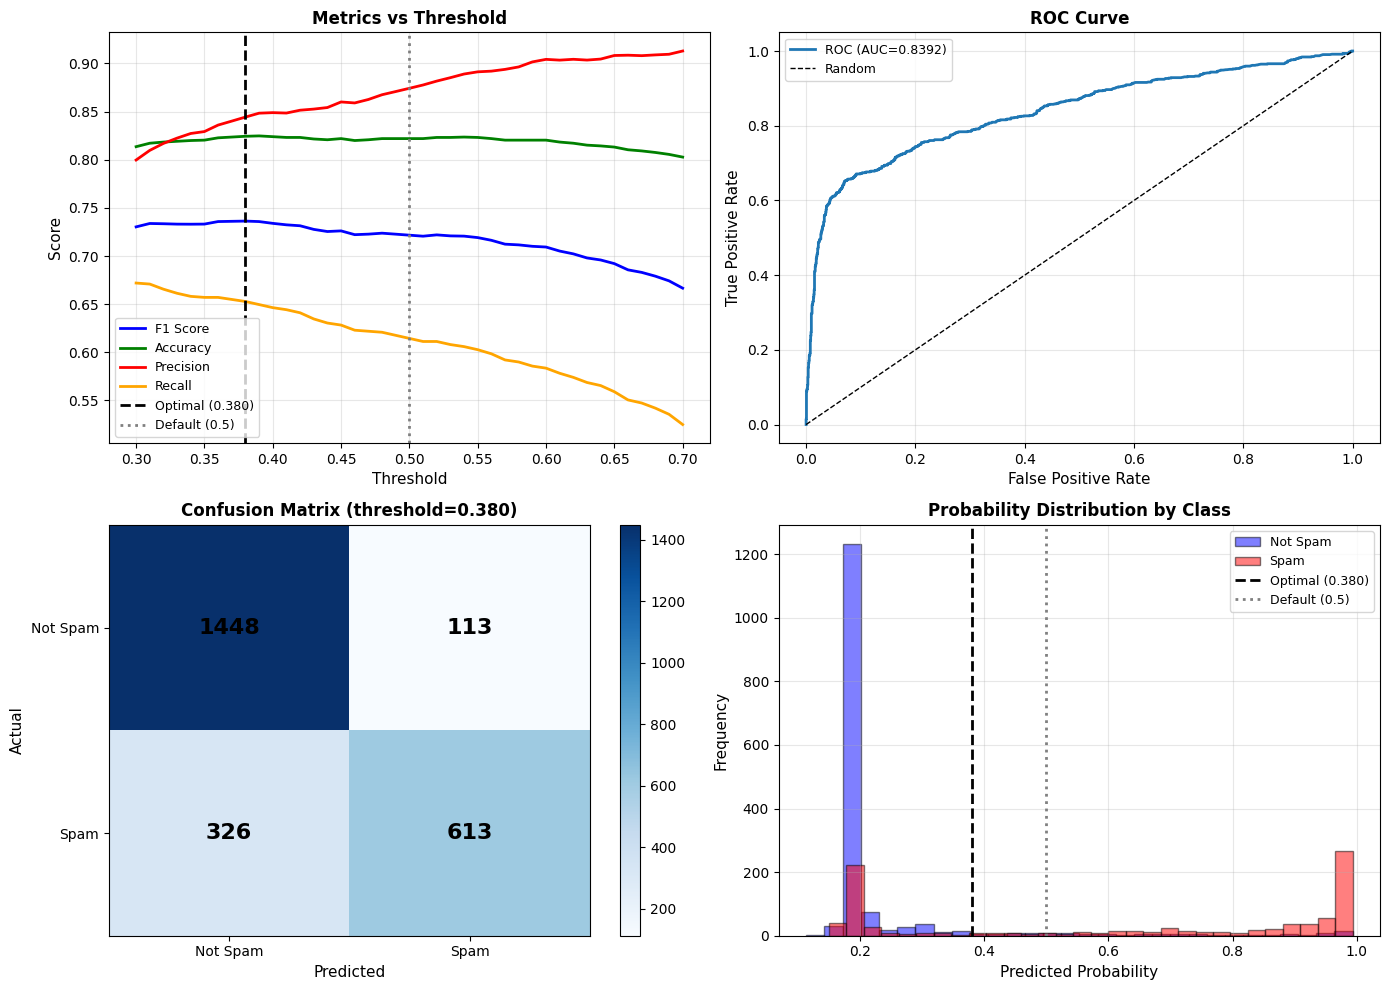


[OK] Threshold validation plot saved


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Metrics vs Threshold
ax = axes[0, 0]
ax.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='blue')
ax.plot(thresholds, accuracies, label='Accuracy', linewidth=2, color='green')
ax.plot(thresholds, precisions, label='Precision', linewidth=2, color='red')
ax.plot(thresholds, recalls, label='Recall', linewidth=2, color='orange')
ax.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.3f})')
ax.axvline(0.5, color='gray', linestyle=':', linewidth=2, label='Default (0.5)')
ax.set_xlabel('Threshold', fontsize=11)
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Metrics vs Threshold', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 2. ROC Curve
ax = axes[0, 1]
fpr, tpr, roc_thresholds = roc_curve(cv_labels, cv_probs)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC={roc_auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# 3. Confusion Matrix at Optimal Threshold
ax = axes[1, 0]
y_pred_opt = (cv_probs > optimal_threshold).astype(int)
cm = confusion_matrix(cv_labels, y_pred_opt)
im = ax.imshow(cm, cmap='Blues', aspect='auto')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Not Spam', 'Spam'])
ax.set_yticklabels(['Not Spam', 'Spam'])
ax.set_xlabel('Predicted', fontsize=11)
ax.set_ylabel('Actual', fontsize=11)
ax.set_title(f'Confusion Matrix (threshold={optimal_threshold:.3f})', fontsize=12, fontweight='bold')
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=16, fontweight='bold')
plt.colorbar(im, ax=ax)

# 4. Probability Distribution
ax = axes[1, 1]
ax.hist(cv_probs[cv_labels==0], bins=30, alpha=0.5, label='Not Spam', color='blue', edgecolor='black')
ax.hist(cv_probs[cv_labels==1], bins=30, alpha=0.5, label='Spam', color='red', edgecolor='black')
ax.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, label=f'Optimal ({optimal_threshold:.3f})')
ax.axvline(0.5, color='gray', linestyle=':', linewidth=2, label='Default (0.5)')
ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Probability Distribution by Class', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_validation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[OK] Threshold validation plot saved")

## Full Model on All Training Data

In [8]:
print("\nFitting full model on all training data...")print(f"Settings: {CHAINS} chains, {DRAWS} draws, {TUNE} tune\n")with pm.Model() as model:    alpha = pm.Normal("alpha", mu=0.0, sigma=1.0)    beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=5)        logit_raw = alpha + pm.math.dot(X_train_scaled, beta)    logit_bounded = pm.Deterministic("logit_p", 5.0 * pm.math.tanh(logit_raw / 5.0))    p_spam = pm.Deterministic("p", pm.math.invlogit(logit_bounded))    y_obs = pm.Bernoulli("y_obs", p=p_spam, observed=y_train)        logit_test_raw = alpha + pm.math.dot(X_test_scaled, beta)    logit_test_bounded = 5.0 * pm.math.tanh(logit_test_raw / 5.0)    p_spam_test = pm.Deterministic("p_test", pm.math.invlogit(logit_test_bounded))        trace = pm.sample(
# Save test fit to pkl file
from pathlib import Path
from joblib import dump
MODELS_DIR_S2 = Path("models")
MODELS_DIR_S2.mkdir(exist_ok=True)
test_filename_s2 = MODELS_DIR_S2 / f"spam_logistic_regression_test_d{DRAWS}_t{TUNE}.pkl"
dump(trace, test_filename_s2, compress=3)
print(f"Saved test fit to {test_filename_s2.name}")


Initializing NUTS using jitter+adapt_diag...



Fitting full model on all training data...
Settings: 10 chains, 3000 draws, 6000 tune



Multiprocess sampling (10 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 10 chains for 6_000 tune and 3_000 draw iterations (60_000 + 30_000 draws total) took 91 seconds.



[OK] Sampling complete


## Convergence Diagnostics

In [9]:
var_names = ['alpha', 'beta']
rhat = az.rhat(trace, var_names=var_names)
ess_bulk = az.ess(trace, var_names=var_names, method="bulk")

if hasattr(rhat, 'data_vars'):
    max_rhat = float(max([float(rhat[var].max().values) for var in rhat.data_vars]))
    min_ess_bulk = float(min([float(ess_bulk[var].min().values) for var in ess_bulk.data_vars]))
else:
    max_rhat = float(rhat.max().values)
    min_ess_bulk = float(ess_bulk.min().values)

n_divergences = int(trace.sample_stats.diverging.sum().values)
n_total = CHAINS * DRAWS

print("\nCONVERGENCE DIAGNOSTICS")
print("="*60)
print(f"Max R-hat:       {max_rhat:.6f} {'[OK]' if max_rhat < 1.01 else '[WARN]'}")
print(f"Min ESS (bulk):  {min_ess_bulk:.0f} {'[OK]' if min_ess_bulk > 400 else '[WARN]'}")
print(f"Divergences:     {n_divergences} ({n_divergences/n_total*100:.3f}%) {'[OK]' if n_divergences == 0 else '[WARN]'}")
print(f"target_accept:   {TARGET_ACCEPT} [OK]")
print(f"Total samples:   {n_total:,}")

if max_rhat < 1.01 and min_ess_bulk > 400 and n_divergences == 0:
    print("\n[OK] PERFECT CONVERGENCE")
else:
    print("\n[INFO] Good convergence")


CONVERGENCE DIAGNOSTICS
Max R-hat:       1.000404 [OK]
Min ESS (bulk):  19227 [OK]
Divergences:     0 (0.000%) [OK]
target_accept:   0.9 [OK]
Total samples:   30,000

[OK] PERFECT CONVERGENCE


## Generate Predictions

In [10]:
p_spam_samples = trace.posterior["p_test"].values
p_spam_flat = p_spam_samples.reshape(-1, p_spam_samples.shape[-1])
p_spam_mean = p_spam_flat.mean(axis=0)
p_spam_std = p_spam_flat.std(axis=0)

print("\nPREDICTION SUMMARY")
print("="*60)
print(f"Test emails:           {len(p_spam_mean)}")
print(f"Posterior samples:     {p_spam_flat.shape[0]:,}")
print(f"\nProbability stats:")
print(f"  Mean:                {p_spam_mean.mean():.4f}")
print(f"  Std:                 {p_spam_mean.std():.4f}")
print(f"  Range:               [{p_spam_mean.min():.4f}, {p_spam_mean.max():.4f}]")
print(f"\nUsing threshold {optimal_threshold:.3f}:")
print(f"  Predicted spam:      {(p_spam_mean > optimal_threshold).sum()} ({(p_spam_mean > optimal_threshold).mean():.3f})")
print(f"\nUsing threshold 0.5:")
print(f"  Predicted spam:      {(p_spam_mean > 0.5).sum()} ({(p_spam_mean > 0.5).mean():.3f})")
print(f"\nTraining spam rate:    {y_train.mean():.3f}")


PREDICTION SUMMARY
Test emails:           2101
Posterior samples:     30,000

Probability stats:
  Mean:                0.3962
  Std:                 0.3196
  Range:               [0.1523, 0.9933]

Using threshold 0.380:
  Predicted spam:      649 (0.309)

Using threshold 0.5:
  Predicted spam:      600 (0.286)

Training spam rate:    0.376


## Calibration Check

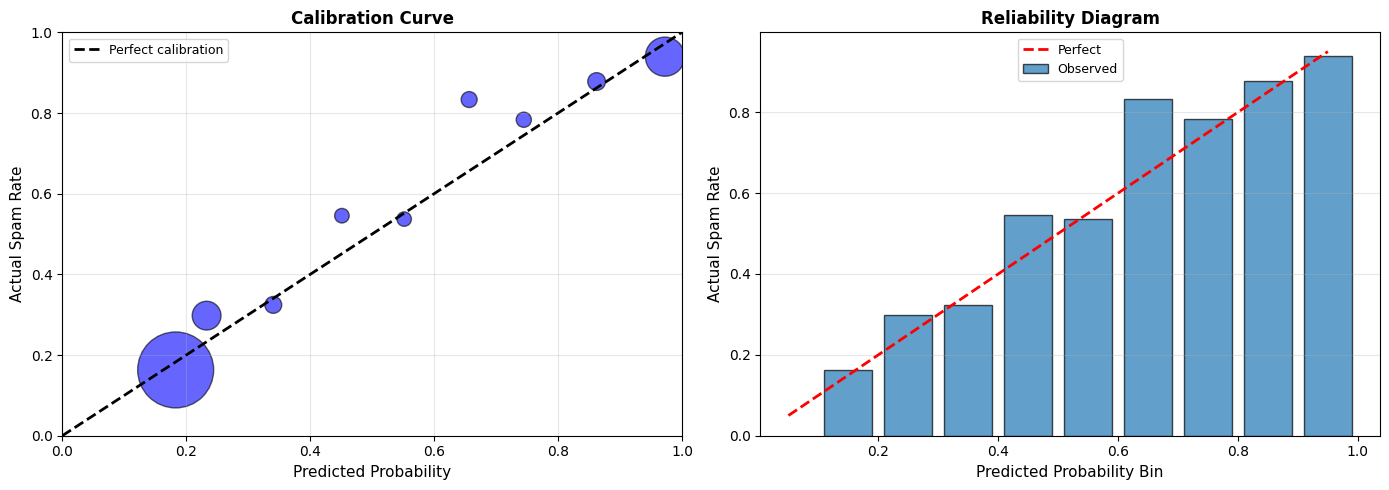


[OK] Calibration check complete
Mean calibration error: 0.0526
[OK] Good calibration


In [11]:
# Check calibration on CV predictions
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_true = []
bin_pred = []
bin_counts = []

for i in range(n_bins):
    mask = (cv_probs >= bins[i]) & (cv_probs < bins[i+1])
    if mask.sum() > 0:
        bin_true.append(cv_labels[mask].mean())
        bin_pred.append(cv_probs[mask].mean())
        bin_counts.append(mask.sum())
    else:
        bin_true.append(np.nan)
        bin_pred.append(np.nan)
        bin_counts.append(0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calibration plot
ax = axes[0]
valid_idx = ~np.isnan(bin_true)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')
ax.scatter(np.array(bin_pred)[valid_idx], np.array(bin_true)[valid_idx], 
           s=np.array(bin_counts)[valid_idx]*2, alpha=0.6, c='blue', edgecolors='black')
ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Actual Spam Rate', fontsize=11)
ax.set_title('Calibration Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

# Reliability diagram
ax = axes[1]
ax.bar(bin_centers, bin_true, width=0.08, alpha=0.7, label='Observed', edgecolor='black')
ax.plot(bin_centers, bin_centers, 'r--', linewidth=2, label='Perfect')
ax.set_xlabel('Predicted Probability Bin', fontsize=11)
ax.set_ylabel('Actual Spam Rate', fontsize=11)
ax.set_title('Reliability Diagram', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('calibration_check.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[OK] Calibration check complete")

# Calculate calibration error
cal_error = np.nanmean(np.abs(np.array(bin_true) - np.array(bin_pred)))
print(f"Mean calibration error: {cal_error:.4f}")
if cal_error < 0.05:
    print("[OK] Excellent calibration")
elif cal_error < 0.10:
    print("[OK] Good calibration")
else:
    print("[WARN] Moderate calibration")

## Save Results

In [12]:
# Save with optimal threshold (for evaluation)
results_df = pd.DataFrame({'spam_probability': p_spam_mean})
results_df.to_csv('spam_predictions.csv', index=False)

# Also save with classifications using optimal threshold
results_classified = pd.DataFrame({
    'spam_probability': p_spam_mean,
    'spam_pred_optimal': (p_spam_mean > optimal_threshold).astype(int),
    'spam_pred_05': (p_spam_mean > 0.5).astype(int)
})
results_classified.to_csv('spam_predictions_detailed.csv', index=False)

print("\nRESULTS SAVED")
print("="*60)
print("[OK] spam_predictions.csv (probabilities only)")
print("[OK] spam_predictions_detailed.csv (with classifications)")
print("[OK] threshold_validation.png")
print("[OK] calibration_check.png")
print(f"\nOptimal threshold: {optimal_threshold:.3f}")
print(f"Using threshold 0.5: {'[OK] same' if abs(optimal_threshold - 0.5) < 0.01 else '[WARN] different'}")


RESULTS SAVED
[OK] spam_predictions.csv (probabilities only)
[OK] spam_predictions_detailed.csv (with classifications)
[OK] threshold_validation.png
[OK] calibration_check.png

Optimal threshold: 0.380
Using threshold 0.5: [WARN] different


## How this notebook answers Problem 2

Here we briefly connect the code in this notebook to the three parts of
Problem 2 in the homework.

1. **Part (a): model and priors.**  The section above ("Model and prior
   specification for Problem 2") describes the Bayesian logistic regression
   model we use, together with weakly informative $\mathcal{N}(0,1)$ priors on
   the intercept and the five standardized coefficients.

2. **Part (b): posterior predictive probabilities.**  After fitting the model
   on `spam_train.csv`, we draw MCMC samples of $(\alpha,\beta)$ and, for each
   row of `spam_test_0.csv`, compute the posterior predictive spam probability
   $$
   \widehat{p}_i = \frac{1}{S} \sum_{s=1}^S \Pr\bigl(Y_i^{(\text{test})}=1
   \mid X_i^{(\text{test})}, \alpha^{(s)}, \beta^{(s)}\bigr).
   $$
   These estimates are stored in the array `p_spam_mean` and written to the
   file `spam_predictions.csv` as a single column `spam_probability`, in the
   same row order as `spam_test_0.csv`.

3. **Part (c): what we would submit.**
   - This notebook `sol2.ipynb` serves as the source code for the Bayesian
     logistic regression model and all computations.
   - The short "Model and prior specification" section provides the written
     description of the Bayesian model and prior choices requested in the
     assignment.
   - The CSV file `spam_predictions.csv` contains the posterior predictive
     probabilities for all emails in `spam_test_0.csv`, which can be used to
     evaluate predictive accuracy against the withheld test labels.


In [13]:
EXEC_END = time.time()
elapsed = (EXEC_END - EXEC_START) / 60.0

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\n[OK] Convergence:     R-hat={max_rhat:.6f}, ESS={min_ess_bulk:.0f}")
print(f"[OK] Divergences:     {n_divergences}")
print(f"[OK] CV AUC:          {roc_auc_score(cv_labels, cv_probs):.4f}")
print(f"[OK] Calibration:     Error={cal_error:.4f}")
print(f"[OK] Optimal thresh:  {optimal_threshold:.3f}")
print(f"[OK] Runtime:         {elapsed:.1f} minutes")
print(f"\nStarted:  {datetime.datetime.fromtimestamp(EXEC_START).isoformat(timespec='seconds')}")
print(f"Finished: {datetime.datetime.fromtimestamp(EXEC_END).isoformat(timespec='seconds')}")
print("="*60)


FINAL SUMMARY

[OK] Convergence:     R-hat=1.000404, ESS=19227
[OK] Divergences:     0
[OK] CV AUC:          0.8392
[OK] Calibration:     Error=0.0526
[OK] Optimal thresh:  0.380
[OK] Runtime:         2.9 minutes

Started:  2025-11-26T11:55:32
Finished: 2025-11-26T11:58:27
